<a href="https://colab.research.google.com/github/KyloRen1/CS_224N_NLP-Course/blob/master/HomeWork2/task3_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1.3: Naive word2vec (40 points)

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch and code from your previous task.

## Results of this task: (30 points)
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)

## Extra questions: (10 points)
 * Intrinsic evaluation: you can find datasets [here](http://download.tensorflow.org/data/questions-words.txt)
 * Extrinsic evaluation: you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchsummary import summary
from collections import Counter
import re
from tqdm import tqdm
from time import time

In [0]:
class CorpusDataset_CBOW(data.Dataset):
    def __init__(self, data_link, window_size=4, dict_size=50000):
        # text preprocessing
        self.dict_size = dict_size
        words_tokenized = self.read_preprocess_text(data_link)
        # creating training samples: ([context_array, target_word])
        self.context_target =  [([words_tokenized[i-(j+1)] for j in range(window_size)] + [words_tokenized[i+(j+1)] for j in range(window_size)],
                                words_tokenized[i]) for i in range(window_size, len(words_tokenized)-window_size)]
        # vocabulary of words
        self.vocab = Counter(words_tokenized)
        # word2index mapping
        self.word2index = {word_tuple[0]: idx for idx, word_tuple in enumerate(self.vocab.most_common(dict_size))}
        # index2word mapping
        self.index2word = list(self.word2index.keys())
        self.vocab_size = len(self.vocab)
        self.window_size = window_size
        
    def read_preprocess_text(self, data_link):
        text = open(data_link, 'r').readline()
        text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)
        text = text.split(' ')
        counter_words = dict(Counter(text).most_common(self.dict_size - 1))
        res = []
        for word in text:
            if word in counter_words and counter_words[word] > 5:
              res.append(word)
            else:
                res.append('UNK')
        return np.array(res)

    def __getitem__(self, idx):
        context = torch.tensor([self.word2index[w] for w in self.context_target[idx][0]])
        target = torch.tensor([self.word2index[self.context_target[idx][1]]])
        return context, target

    def __len__(self):
        return len(self.context_target)

In [0]:
class CBOW_Model(nn.Module):
    def __init__(self, vocabulary_size, embedding_dim):
        super(CBOW_Model, self).__init__()
        self.embedding = nn.Embedding(num_embeddings = vocabulary_size, 
                                      embedding_dim = embedding_dim)
        self.linear = nn.Linear(in_features = embedding_dim, 
                                out_features = vocabulary_size, bias=True)
        
    def forward(self, x):
        embedding = torch.sum(self.embedding(x), dim=1)
        output = self.linear(embedding)
        log_probabilities = F.log_softmax(output, dim=1)
        return log_probabilities

In [0]:
BATCH_SIZE = 256
WINDOW_SIZE = 4
EMBEDDING_DIM = 100
LR = 0.001
EPOCHS = 10
DICT_SIZE = 50000

In [0]:
text_data = CorpusDataset_CBOW('text8', window_size = WINDOW_SIZE, dict_size = DICT_SIZE)
dataloader = data.DataLoader(text_data, batch_size = BATCH_SIZE)

In [6]:
text_data.vocab_size

50000

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
criterion = nn.NLLLoss()
model = CBOW_Model(vocabulary_size=text_data.vocab_size, 
                   embedding_dim=EMBEDDING_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [9]:
start_time = time()
losses = []

for epoch in range(EPOCHS):
    epoch_loss = []
    for context, target in tqdm(dataloader):
        if context.size()[0] != BATCH_SIZE:
            continue
        target = target.squeeze(1).to(device)
        context = context.to(device)
        
        model.zero_grad()
        log_probabilities = model(context)
        loss = criterion(log_probabilities, target)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

    print(f'[{epoch+1}]/[{EPOCHS}] loss: {np.mean(epoch_loss)}')
    losses.append(np.mean(epoch_loss))

print('Training time: ', time() - start_time)

  0%|          | 10/66427 [00:00<12:03, 91.76it/s]

[1]/[10] loss: 6.681146580664779


  0%|          | 10/66427 [00:00<11:36, 95.29it/s]

[2]/[10] loss: 6.305337285355164


  0%|          | 10/66427 [00:00<11:19, 97.81it/s]

[3]/[10] loss: 6.146433343162447


  0%|          | 9/66427 [00:00<12:20, 89.68it/s]

[4]/[10] loss: 6.05495057507151


  0%|          | 10/66427 [00:00<11:23, 97.11it/s]

[5]/[10] loss: 5.999689373953378


  0%|          | 10/66427 [00:00<11:44, 94.21it/s]

[6]/[10] loss: 5.9618621696801455


  0%|          | 10/66427 [00:00<11:07, 99.54it/s]

[7]/[10] loss: 5.934188527358572


  0%|          | 12/66427 [00:00<09:49, 112.70it/s]

[8]/[10] loss: 5.913182834771628


  0%|          | 10/66427 [00:00<11:21, 97.43it/s]

[9]/[10] loss: 5.89682124354338


100%|██████████| 66427/66427 [11:24<00:00, 97.07it/s]

[10]/[10] loss: 5.883940744853345
Training time:  6706.384942531586


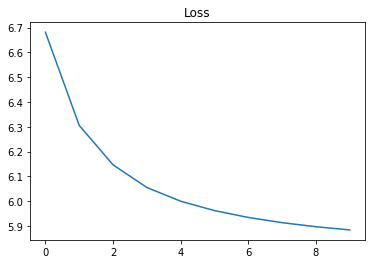

In [10]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(losses);

In [11]:
embeddings = model.embedding.weight.to('cpu').data.numpy()
embeddings

array([[-0.4022423 ,  0.7532044 ,  0.2799737 , ..., -0.17317273,
        -0.17590256, -0.04866748],
       [ 0.99423295, -0.24744202, -0.24730878, ..., -0.04020196,
         0.03534862, -0.10835966],
       [ 0.23008418, -0.09964669,  0.14236698, ..., -0.2512502 ,
        -0.11034757, -0.27096155],
       ...,
       [-1.4428645 , -0.08213777,  0.62533116, ...,  2.220085  ,
        -1.7052232 , -0.10899027],
       [ 0.03183486, -1.771235  , -1.8249097 , ..., -0.30762056,
        -0.30401656,  0.02860015],
       [ 0.7840356 , -0.9566067 , -1.2784952 , ..., -0.51947296,
         0.13654034, -1.1315324 ]], dtype=float32)

In [12]:
def token_word_vector_map(embedding, token, text_dataset):
  token_index = text_dataset.word2index[token]
  token_vector = embedding[token_index]
  return token, token_vector

token_word_vector_map(embeddings, 'age', text_data)

('age', array([-0.6024982 , -0.4084463 ,  0.90771943,  0.18216471,  0.90711945,
         1.1807725 , -0.5420461 ,  0.5760882 , -0.22235654,  2.1517227 ,
        -0.2485275 , -1.9175882 ,  0.7104974 , -0.15744649, -0.32437077,
         0.9339079 , -0.28767115,  0.1121586 ,  0.92223746, -1.3882759 ,
        -0.27391857, -0.74629104,  0.5472532 ,  0.02687891,  0.37996033,
         1.0473399 ,  0.02327094, -0.04698237,  0.5938375 ,  0.02407979,
        -0.31368384,  0.5945097 , -0.40640828, -0.30794588, -0.1280634 ,
         1.6987803 ,  0.83751565, -0.21764275, -1.5023483 ,  0.11329606,
        -0.32767773,  1.1980069 , -0.02751677, -0.71511346, -0.4997123 ,
        -0.2834245 ,  0.4322643 ,  0.10889188,  0.21886389,  0.304195  ,
         0.7067448 ,  0.7165168 , -0.63048667, -0.7045384 ,  0.7307991 ,
         0.33626145,  0.7500926 ,  0.3604682 ,  0.52371013,  0.00573389,
        -0.7151149 , -0.6671353 ,  0.39783132, -0.4696437 , -0.95850503,
         0.78722686, -0.14284292,  0.5186407

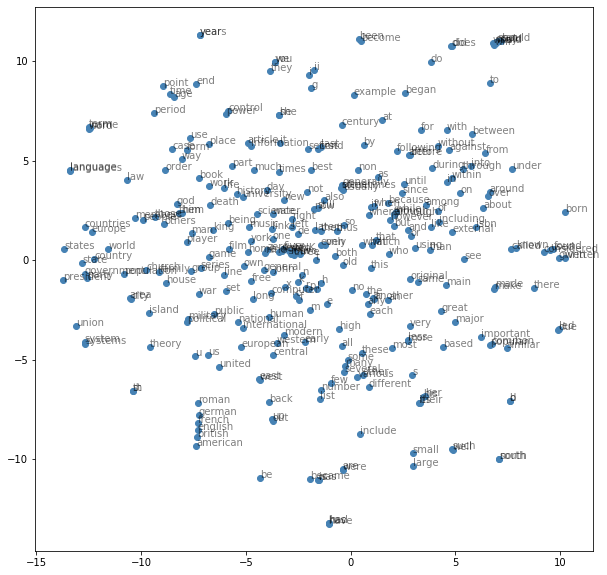

In [13]:
def visualization(embedding, text_dataset, number_words = 300):
  from sklearn.manifold import TSNE
  embed_tsne = TSNE(n_components=2).fit_transform(embedding[:number_words, :])
  fig, ax = plt.subplots(figsize=(10, 10))
  for idx in range(number_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(text_dataset.index2word[idx], (embed_tsne[idx, 0], 
                                                embed_tsne[idx, 1]), alpha=0.5)  
visualization(embeddings, text_data)

In [14]:
def intrinsic_evaluation_test(embeddings, text_data):
  capital_1 = 'Athens'.lower()
  country_1 = 'Greece'.lower()
  capital_2 = 'Beijing'.lower()
  country_2 = 'China'.lower()
  country_3 = 'Kenya'.lower()

  cap_1_idx = text_data.word2index[capital_1]
  cap_2_idx = text_data.word2index[capital_2]
  country_1_idx = text_data.word2index[country_1]
  country_2_idx = text_data.word2index[country_2]
  country_3_idx = text_data.word2index[country_3]

  cap_1_embed = embeddings[cap_1_idx]
  cap_2_embed = embeddings[cap_2_idx]
  country_1_embed = embeddings[country_1_idx]
  country_2_embed = embeddings[country_2_idx]
  country_3_embed = embeddings[country_3_idx]

  res = cap_1_embed + country_2_embed - country_1_embed
  print('Similarity (Athens + China - Greece :: Beijing): ',  
        np.dot(res, cap_2_embed) / (np.linalg.norm(res) * 
                                    np.linalg.norm(cap_2_embed)))
  print('Similarity (Athens + China - Greece :: Kenya): ',  
        np.dot(res, country_3_embed) / (np.linalg.norm(res) * 
                                        np.linalg.norm(country_3_embed)))

intrinsic_evaluation_test(embeddings, text_data)

Similarity (Athens + China - Greece :: Beijing):  0.5286288
Similarity (Athens + China - Greece :: Kenya):  0.039029542


In [17]:
def intrinsic_evaluation_test_2(embeddings, text_data):
  word1 = 'Woman'.lower()
  word2 = 'King'.lower()
  word3 = 'Man'.lower()
  res_word = 'Queen'.lower()
  adv_word = 'Monarch'.lower()

  word1_idx = text_data.word2index[word1]
  word2_idx = text_data.word2index[word2]
  word3_idx = text_data.word2index[word3]
  res_word_idx = text_data.word2index[res_word]
  adv_word_idx = text_data.word2index[adv_word]

  word_1_embed = embeddings[word1_idx]
  word_2_embed = embeddings[word2_idx]
  word_3_embed = embeddings[word3_idx]
  res_word_embed = embeddings[res_word_idx]
  adv_word_embed = embeddings[adv_word_idx]

  res = word_1_embed + word_2_embed - word_3_embed
  print('Similarity (woman + king - man :: queen): ',  
        np.dot(res, res_word_embed) / (np.linalg.norm(res) * 
                                    np.linalg.norm(res_word_embed)))
  print('Similarity (woman + king - man :: monarch): ',  
        np.dot(res, adv_word_embed) / (np.linalg.norm(res) * 
                                    np.linalg.norm(adv_word_embed)))

intrinsic_evaluation_test_2(embeddings, text_data)

Similarity (woman + king - man :: queen):  0.46813256
Similarity (woman + king - man :: monarch):  0.56245184
